# Рекомендация тарифов

## Изучение данных

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:
*	сalls — количество звонков,
*	minutes — суммарная длительность звонков в минутах,
*	messages — количество sms-сообщений,
*	mb_used — израсходованный интернет-трафик в Мб,
*	is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [ ]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


У нас есть данные по 3214 абонентам Мегалайна. По условию задания данные уже предобработаны - пропусков и выбросов нет. Тип тарифа ("Ультра" - 1 или "Смарт" - 0) хранится в переменной is_ultra, доля тарифа "Ультра" - 0.306472. 

## Разбиение на выборки

Наша задача: "построить модель для задачи классификации, которая выберет подходящий тариф". Исходя из задачи, целевым признаком (target) мы нарекаем is_ultra: предлагаем пользователю тариф "Ультра" (1) или "Смарт" (0). Остальные признаки объединяем в features.

In [ ]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

Разделим нашу выборку на три: train, valid и test в соотношении 3:1:1. Для этого сначала выделим тренировочную выборку (60%), а следующим шагом разделим оставшиеся 40% на валидационную и тестовую. 

In [ ]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

In [ ]:
print('Размер train:', len(features_train))
print('Размер valid:', len(features_valid))
print('Размер test:', len(features_test))

Размер train: 1928
Размер valid: 643
Размер test: 643


Проверим соотношение.

In [ ]:
print('Доля train:', len(features_train)/len(data))
print('Доля valid:', len(features_valid)/len(data))
print('Доля test:', len(features_test)/len(data))

Доля train: 0.5998755444928439
Доля valid: 0.2000622277535781
Доля test: 0.2000622277535781


60% - тренировочная, 20% - валидационная, 20% - тестовая. Всё сходится. 

In [ ]:
print('"Ультра" в target_train:', target_train.sum(), '|', '"Смарт" в target_train:', (target_train.count() - target_train.sum()))
print('"Ультра" в target_valid:', target_valid.sum(), '|', '"Смарт" в target_valid:', (target_valid.count() - target_valid.sum()))
print('"Ультра" в target_test:', target_test.sum(), '|', '"Смарт" в target_test:', (target_test.count() - target_test.sum()))


"Ультра" в target_train: 593 | "Смарт" в target_train: 1335
"Ультра" в target_valid: 189 | "Смарт" в target_valid: 454
"Ультра" в target_test: 203 | "Смарт" в target_test: 440


## Исследование моделей

В рамках задачи классификации исследуем три модели:
* решающее дерево
* случайный лес
* логистическая регрессия

### Решающее дерево

Обучим модели с глубиной дерева от 1 до 21 и выберем лучшее по показателю accuracy. Лучшую модель сохраним в best_model_tree. 

In [ ]:
best_model_tree = None
depth_of_best_model = 0
best_result_tree = 0
depths = []
accuracy_scores = []
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    depths.append(depth)
    accuracy_scores.append(result)
    if result > best_result_tree:
        best_model_tree = model
        depth_of_best_model = depth
        best_result_tree = result
    print("Depth:", depth, "|", "Accuracy:", result)
print("---------------------------------------------------------------")        
print("Accuracy лучшей модели:", best_result_tree, "при глубине дерева", depth_of_best_model)

Depth: 1 | Accuracy: 0.7542768273716952
Depth: 2 | Accuracy: 0.7822706065318819
Depth: 3 | Accuracy: 0.7853810264385692
Depth: 4 | Accuracy: 0.7791601866251944
Depth: 5 | Accuracy: 0.7791601866251944
Depth: 6 | Accuracy: 0.7838258164852255
Depth: 7 | Accuracy: 0.7822706065318819
Depth: 8 | Accuracy: 0.7791601866251944
Depth: 9 | Accuracy: 0.7822706065318819
Depth: 10 | Accuracy: 0.7744945567651633
Depth: 11 | Accuracy: 0.7620528771384136
Depth: 12 | Accuracy: 0.7620528771384136
Depth: 13 | Accuracy: 0.7558320373250389
Depth: 14 | Accuracy: 0.7589424572317263
Depth: 15 | Accuracy: 0.7465007776049767
Depth: 16 | Accuracy: 0.7340590979782271
Depth: 17 | Accuracy: 0.7356143079315708
Depth: 18 | Accuracy: 0.7309486780715396
Depth: 19 | Accuracy: 0.7278382581648523
Depth: 20 | Accuracy: 0.7216174183514774
---------------------------------------------------------------
Accuracy лучшей модели: 0.7853810264385692 при глубине дерева 3


Лучшей оказалась модель с глубиной дерева 3 (accuracy - 0.7853810264385692). Дерево:

[Text(279.0, 380.52, 'X[3] <= 26244.135\nentropy = 0.426\nsamples = 1928\nvalue = [1335, 593]'),
 Text(139.5, 271.8, 'X[1] <= 755.485\nentropy = 0.375\nsamples = 1736\nvalue = [1302, 434]'),
 Text(69.75, 163.07999999999998, 'X[2] <= 115.0\nentropy = 0.337\nsamples = 1622\nvalue = [1274, 348]'),
 Text(34.875, 54.360000000000014, 'entropy = 0.311\nsamples = 1570\nvalue = [1267, 303]'),
 Text(104.625, 54.360000000000014, 'entropy = 0.233\nsamples = 52\nvalue = [7, 45]'),
 Text(209.25, 163.07999999999998, 'X[0] <= 128.5\nentropy = 0.371\nsamples = 114\nvalue = [28, 86]'),
 Text(174.375, 54.360000000000014, 'entropy = 0.45\nsamples = 76\nvalue = [26, 50]'),
 Text(244.125, 54.360000000000014, 'entropy = 0.1\nsamples = 38\nvalue = [2, 36]'),
 Text(418.5, 271.8, 'X[3] <= 31565.21\nentropy = 0.285\nsamples = 192\nvalue = [33, 159]'),
 Text(348.75, 163.07999999999998, 'X[1] <= 592.61\nentropy = 0.394\nsamples = 111\nvalue = [30, 81]'),
 Text(313.875, 54.360000000000014, 'entropy = 0.45\nsamples 

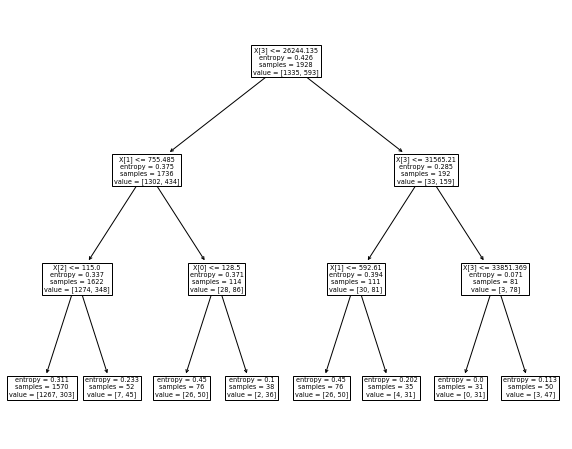

In [ ]:
plt.figure(figsize=(10,8))
tree.plot_tree(best_model_tree)

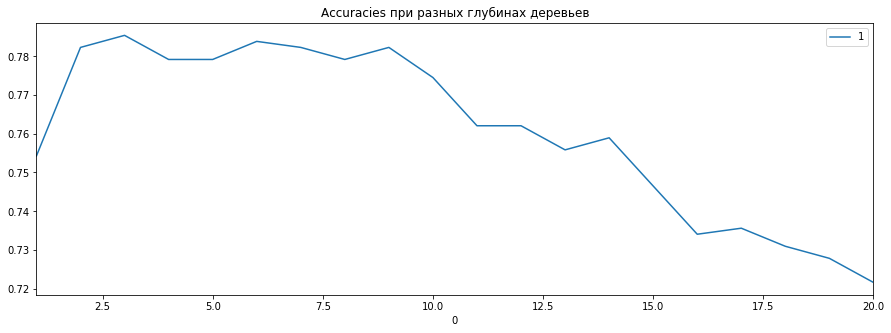

In [ ]:
depths = pd.Series(depths) 
accuracy_scores = pd.Series(accuracy_scores) 
pd.concat([depths, accuracy_scores], axis=1).plot(x=0, y=1, figsize=(15,5), title='Accuracies при разных глубинах деревьев')

На графике видим, что после глубины дерева 9 показатель точности стабильно падает - модель переобучается. Видимо, при выборке большего размера была бы другая картина. 

### Случайный лес

Обучим модели случайного леса с разным количеством оценщиков-деревьев и с разными глубинами деревьев. Лучший по accuracy вариант сохраним в best_model_forest.

In [ ]:
best_model_forest = None
est_of_best_model = 0
depth_of_best_model = 0
best_result_forest = 0
depths = []
accuracy_scores = []
forest = [] 
for est in range(10, 150, 10):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        forest.append(est)
        depths.append(depth)
        accuracy_scores.append(result)
        if result > best_result_forest:
            best_model_forest = model
            est_of_best_model = est
            depth_of_best_model = depth
            best_result_forest = result
            print("n_estimators:", est, "|", "Depth:", depth, "|", "Accuracy:", result)
print("-----------------------------------------------------------------------------------------")        
print("Accuracy лучшей модели:", best_result_forest, "при количестве оценщиков", est_of_best_model, "при глубине дерева", depth_of_best_model)

n_estimators: 10 | Depth: 1 | Accuracy: 0.7558320373250389
n_estimators: 10 | Depth: 2 | Accuracy: 0.7776049766718507
n_estimators: 10 | Depth: 3 | Accuracy: 0.7853810264385692
n_estimators: 10 | Depth: 4 | Accuracy: 0.7900466562986003
n_estimators: 10 | Depth: 5 | Accuracy: 0.7931570762052877
n_estimators: 10 | Depth: 6 | Accuracy: 0.8009331259720062
n_estimators: 30 | Depth: 7 | Accuracy: 0.80248833592535
n_estimators: 40 | Depth: 8 | Accuracy: 0.8087091757387247
-----------------------------------------------------------------------------------------
Accuracy лучшей модели: 0.8087091757387247 при количестве оценщиков 40 при глубине дерева 8


Лучшей оказалась модель с 40 деревьями и глубиной дерева 8: accuracy = 0.8087091757387247

In [ ]:
forest = pd.Series(forest)
depths = pd.Series(depths) 
accuracy_scores = pd.Series(accuracy_scores) 
forest_data = pd.concat([forest, depths, accuracy_scores], axis=1)
forest_data.columns = ['est', 'depth', 'accuracy']
forest_data.sample(3)

,est,depth,accuracy
103,110,4,0.788491
50,60,1,0.763608
53,60,4,0.786936


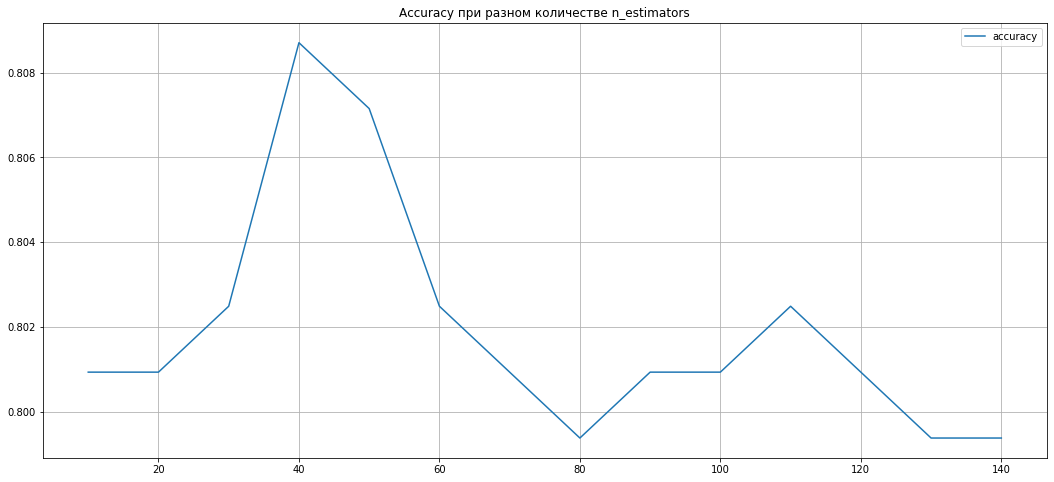

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(forest_data.pivot_table(index='est', values='accuracy', aggfunc='max'), label='accuracy')
plt.title('Accuracy при разном количестве n_estimators')
plt.legend()
plt.grid(True)
plt.show()

Динамика точности моделей при разных количествах оценщиков и пик на 40. Если мы увеличим est до 600, то увидим, что помимо того, что обучение занимает очень много времени, в районе 300 est, accuracy начинает расти, затем снова падает, и после примерно 550 стабилизируется примерно на 0.802. 

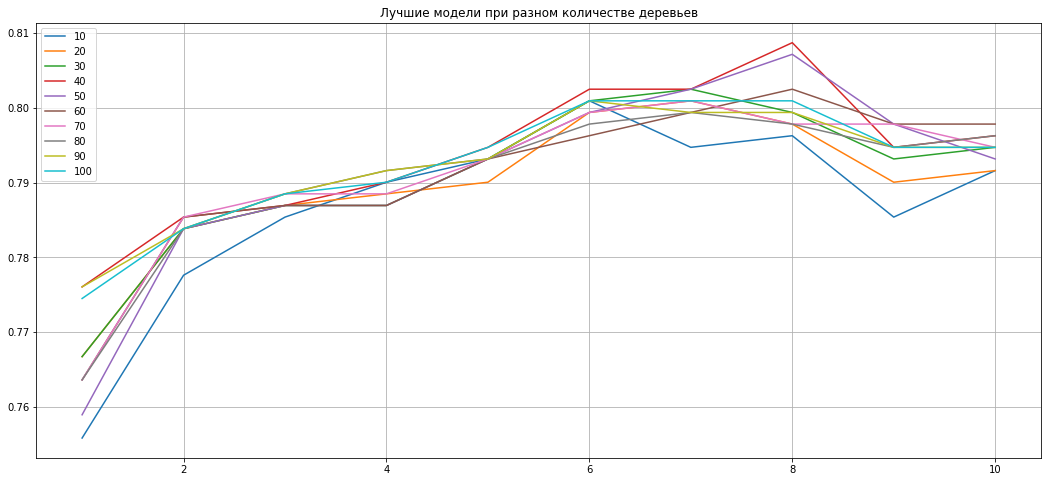

In [ ]:
plt.figure(figsize=(18,8))
for i, group_data in forest_data.query('est <= 100').groupby('est'):
    plt.plot(group_data.pivot_table(index='depth', values='accuracy', aggfunc='max'), label=i)
    plt.title('Лучшие модели при разном количестве деревьев')
    plt.legend()
    plt.grid(True)
plt.show()

Здесь можно рассмотреть лучшие модели при количестве деревьев до 100. Лучший показатель на 40 и 50 деревьях. После глубины дерева 8 все снижают accuracy. 

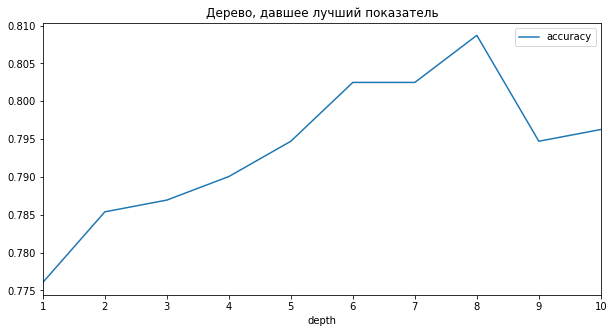

In [ ]:
forest_data.query('est == 40').plot(x='depth', y='accuracy', figsize=(10,5), title='Дерево, давшее лучший показатель')

### Логистическая регрессия

Обучим модели логистической регрессии с разным количествои итераций и разной деталиацией для решателя liblinear

In [ ]:
best_model_logr = None
best_max_iter = 0
best_result_logr = 0
iterations = []
accuracy_scores = []
for iteration in range(1,51):
    for verb in range(1,6):
        model = LogisticRegression(random_state=12345, max_iter = iteration, verbose=verb)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        iterations.append(iteration)
        accuracy_scores.append(result)
        print('max_iter:', iteration, '|','accuracy:', result, '|', 'verbose', verb)
        if result > best_result_logr:
            best_result_logr = result
            best_max_iter = iteration
            best_verbose = verb
            best_model_logr = model
print("-------------------------------------------------------------------") 
print('Accuracy лучшей модели', best_result_logr,'при количестве итераций', best_max_iter, 'при степени детализации для liblinear', best_verbose)

[LibLinear]max_iter: 1 | accuracy: 0.7060653188180405 | verbose 1
[LibLinear]max_iter: 1 | accuracy: 0.7060653188180405 | verbose 2
[LibLinear]max_iter: 1 | accuracy: 0.7060653188180405 | verbose 3
[LibLinear]max_iter: 1 | accuracy: 0.7060653188180405 | verbose 4
[LibLinear]max_iter: 1 | accuracy: 0.7060653188180405 | verbose 5
[LibLinear]max_iter: 2 | accuracy: 0.7060653188180405 | verbose 1
[LibLinear]max_iter: 2 | accuracy: 0.7060653188180405 | verbose 2
[LibLinear]max_iter: 2 | accuracy: 0.7060653188180405 | verbose 3
[LibLinear]max_iter: 2 | accuracy: 0.7060653188180405 | verbose 4
[LibLinear]max_iter: 2 | accuracy: 0.7060653188180405 | verbose 5
[LibLinear]max_iter: 3 | accuracy: 0.7060653188180405 | verbose 1
[LibLinear]max_iter: 3 | accuracy: 0.7060653188180405 | verbose 2
[LibLinear]max_iter: 3 | accuracy: 0.7060653188180405 | verbose 3
[LibLinear]max_iter: 3 | accuracy: 0.7060653188180405 | verbose 4
[LibLinear]max_iter: 3 | accuracy: 0.7060653188180405 | verbose 5
[LibLinear

Лучшей оказалась модель при количестве итераций от 29 и степени детализации для liblinear 1

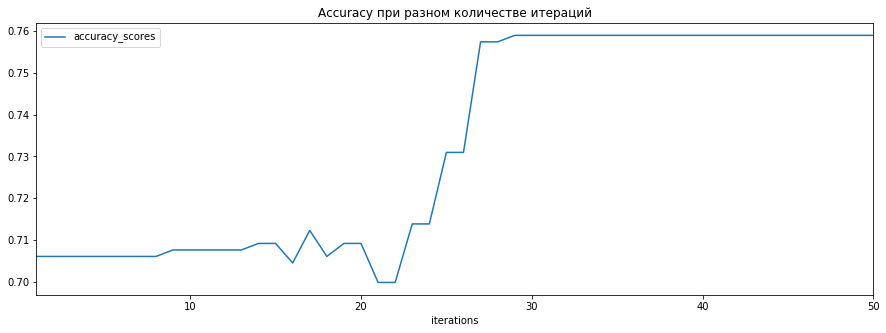

In [ ]:
iterations = pd.Series(iterations)
accuracy_scores = pd.Series(accuracy_scores)
log_reg_data = pd.concat([iterations, accuracy_scores], axis=1)
log_reg_data.columns = ['iterations', 'accuracy_scores']
log_reg_data.plot(x = 'iterations', y = 'accuracy_scores', figsize=(15,5), title='Accuracy при разном количестве итераций')

На графике видим, что количество итераций, дойдя до показателя в 29, делают accuracy стабильной - 0.7589424572317263.

### Вывод

Нам удалось обучить три модели, точность которых на валидационной выборке оказалась выше 0.75. Теперь нужно посмотреть, как они поведут себя на тестовой выборке.

## Тестирование

Посмотрим на качество предстказаний лучших моделей на тестовой выборке.

In [ ]:
predictions_tree = best_model_tree.predict(features_test)
result_tree = accuracy_score(target_test, predictions_tree)
print('Точность лучшей модели дерева решений:', result_tree)

predictions_forest = best_model_forest.predict(features_test)
result_forest = accuracy_score(target_test, predictions_forest)
print('Точность лучшей модели случайного леса:', result_forest)

predictions_logr = best_model_logr.predict(features_test)
result_logr = accuracy_score(target_test, predictions_logr)
print('Точность лучшей модели логистической регрессии:', result_logr)

Точность лучшей модели дерева решений: 0.7791601866251944
Точность лучшей модели случайного леса: 0.7962674961119751
Точность лучшей модели логистической регрессии: 0.7402799377916018


Самый высокий показатель accuracy по-прежнему у модели случайного леса. Вероятно, именно её стоит рассматривать как самую подходящую при предложении клиентам варианта тарифа. 

## Проверка модели на адекватность

Мы можем проверить, насколько адекватно наши модели распределяют по классам данные, то есть убедиться, что это происходит неслучайным образом.
Мы уже оценивали модели по accuracy (доля правильных ответов алгоритма). Оценим другие метрики - precision (точность - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными) и recall (полнота - доля объектов положительного класса из всех объектов положительного класса, предсказанных алгоритмом), и их гармоническое среднее значение - f1-мера.

### Рассмотрим другие метрики

#### confusion_matrix

Рассмотрим матрицу путаницы, которая принимает в качестве входных данных фактические метки и предсказанные метки.

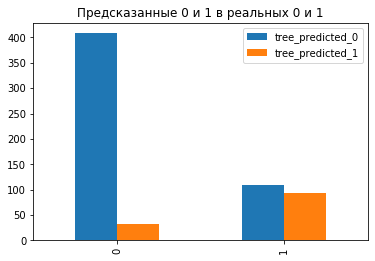

In [ ]:
confusion_matrix_test_tree = confusion_matrix(target_test, predictions_tree)
confusion_matrix_test_tree_df = pd.DataFrame(confusion_matrix_test_tree, columns = ['tree_predicted_0', 'tree_predicted_1'])
confusion_matrix_test_tree_df['actual'] = ['target_0', 'target_1']
confusion_matrix_test_tree_df = confusion_matrix_test_tree_df.set_index(confusion_matrix_test_tree_df['actual']).drop(['actual'], axis=1).reset_index()
confusion_tree = pd.Series([confusion_matrix_test_tree_df.loc[1,'tree_predicted_0'], confusion_matrix_test_tree_df.loc[0,'tree_predicted_1']])
confusion_matrix_test_tree_df.plot(kind='bar', title='Предсказанные 0 и 1 в реальных 0 и 1')

Алгоритм решающего дерева минимально ошибся в тарифе "Смарт" (0), тогда как в тарифе "Ультра" здорово запутался. Настолько, что в предсказанных "Ультра" больше половины занял "Смарт".

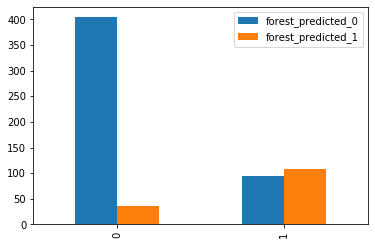

In [ ]:
confusion_matrix_test_forest = confusion_matrix(target_test, predictions_forest)
confusion_matrix_test_forest_df = pd.DataFrame(confusion_matrix_test_forest, columns = ['forest_predicted_0', 'forest_predicted_1'])
confusion_matrix_test_forest_df['actual'] = ['target_0', 'target_1']
confusion_matrix_test_forest_df = confusion_matrix_test_forest_df.set_index(confusion_matrix_test_forest_df['actual']).drop(['actual'], axis=1).reset_index()
confusion_forest = pd.Series([confusion_matrix_test_forest_df.loc[1,'forest_predicted_0'], confusion_matrix_test_forest_df.loc[0,'forest_predicted_1']])
confusion_matrix_test_forest_df.plot(kind='bar')

Алгоритм случайного леса выдал схожие трудности с классификацией "Ультра", что и решающее дерево, но всё же справился лучше - "Ультра" в "Ультра" больше, чем "Смарта".

In [ ]:
confusion_matrix_test_logr = confusion_matrix(target_test, predictions_logr)
confusion_matrix_test_logr_df = pd.DataFrame(confusion_matrix_test_logr, columns = ['logr_predicted_0', 'logr_predicted_1'])
confusion_matrix_test_logr_df['actual'] = ['target_0', 'target_1']
confusion_matrix_test_logr_df = confusion_matrix_test_logr_df.set_index(confusion_matrix_test_logr_df['actual']).drop(['actual'], axis=1).reset_index()
confusion_logr = pd.Series([confusion_matrix_test_logr_df.loc[1,'logr_predicted_0'], confusion_matrix_test_logr_df.loc[0,'logr_predicted_1']])

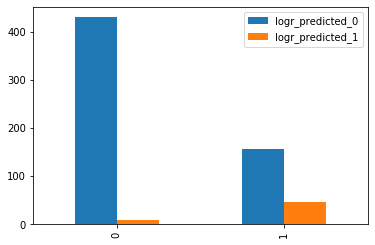

In [ ]:
confusion_matrix_test_logr_df.plot(kind='bar')

У логистической регрессии максимальный провал в распознавании "Ультра".

Матрицы путаницы предсказаний трёх моделей. 

In [ ]:
confusion_matrix_test = confusion_matrix_test_tree_df.merge(confusion_matrix_test_forest_df, on='actual', how='outer')
confusion_matrix_test = confusion_matrix_test.merge(confusion_matrix_test_logr_df, on='actual', how='outer')
confusion_matrix_test

,actual,tree_predicted_0,tree_predicted_1,forest_predicted_0,forest_predicted_1,logr_predicted_0,logr_predicted_1
0,target_0,408,32,404,36,430,10
1,target_1,110,93,95,108,157,46


Логистическая регрессия лучше всех справилась со "Смартом", но хуже всех - с "Ультра". Помним, что в нашей небольшой выборке абоненты "Ультра" составляют треть всех абонентов. Вероятно, этого мало, чтобы научиться их распознавать.

Лучше всех себя показала модель случайного леса. У неё меньше всего сумма ошибочно определённых не в те классы объектов. На таблице ниже, отображающей ложные результаты трёх моделей, это хорошо видно.

In [ ]:
real_tarif = pd.Series([len(target_test) - target_test.sum(), target_test.sum()])
false_tarif = pd.Series(['false_smart', 'false_ultra'])
confusion_models = pd.concat([real_tarif, false_tarif, confusion_tree, confusion_forest, confusion_logr], axis=1)
confusion_models.columns = ['real_tarif', 'false_tarif','confusion_tree', 'confusion_forest', 'confusion_logr']
confusion_models

,real_tarif,false_tarif,confusion_tree,confusion_forest,confusion_logr
0,440,false_smart,110,95,157
1,203,false_ultra,32,36,10


В target_test 
* Смарт - 440
* "Ультра" - 203

tree
* false_ultra - непризнанный "Смарт" ("Смарт", попавший в "Ультра") - 32
* false_smart - непризнанный "Ультра" ("Ультра", попавший в "Смарт") - 110

forest
* false_ultra - непризнанный "Смарт" - 36
* false_smart - непризнанный "Ультра" - 95

logr
* false_ultra - непризнанный "Смарт" - 10
* false_smart - непризнанный "Ультра" - 157

#### accuracy

Уже рассмотренные нам accuracy в одной таблице.

In [ ]:
accuracy_score_models = pd.DataFrame([accuracy_score(target_test, predictions_tree), accuracy_score(target_test, predictions_forest), accuracy_score(target_test, predictions_logr)], ['tree', 'forest', 'logr'], columns=['accuracy_score'])
accuracy_score_models

,accuracy_score
tree,0.779160
forest,0.796267
logr,0.740280


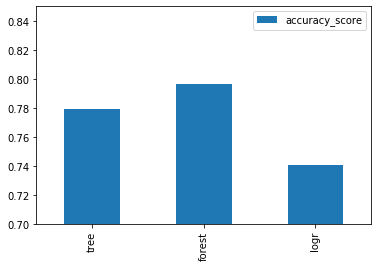

In [ ]:
accuracy_score_models.plot(kind='bar', ylim=(0.7,0.85))

У модели случайного леса  accuracy_score выше.

#### precision

- precision_score_0 - доля реальных "Смарт" в предсказанных "Смарт"
- precision_score_1 - доля реальных "Ультра" в предсказанных "Ультра"

In [ ]:
precision_score_models = pd.DataFrame([precision_score(target_test, predictions_tree, average=None), precision_score(target_test, predictions_forest, average=None), precision_score(target_test, predictions_logr, average=None)], ['tree', 'forest', 'logr'], columns=['precision_score_0', 'precision_score_1'])
precision_score_models

,precision_score_0,precision_score_1
tree,0.787645,0.744000
forest,0.809619,0.750000
logr,0.732538,0.821429


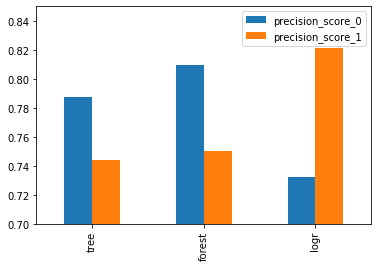

In [ ]:
precision_score_models.plot(kind='bar', ylim=(0.7,0.85))

Алгоритмы решающего дерева и случайного леса ошибались примерно одинаково:в "Смарт" на четверть, в "Ультра" на треть.
Из-за того, что алгоритм логарифмической регресси записал так много "Ультра" в "Смарт", показатель у "Смарт" такой низкий, а у "Ультра" высокий (угадал мало, но правильно).

#### recall

- recall_score_0 - доля правильно предсказанных "Смарт" в реальных "Смарт"
- recall_score_1 - доля правильно предсказанных "Ультра" в реальных "Ультра"

In [ ]:
recall_score_models = pd.DataFrame([recall_score(target_test, predictions_tree, average=None), recall_score(target_test, predictions_forest, average=None), recall_score(target_test, predictions_logr, average=None)], ['tree', 'forest', 'logr'], columns=['recall_score_0', 'recall_score_1'])
recall_score_models

,recall_score_0,recall_score_1
tree,0.927273,0.458128
forest,0.918182,0.532020
logr,0.977273,0.226601


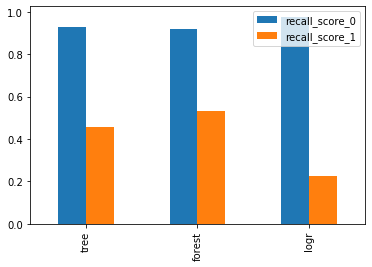

In [ ]:
recall_score_models.plot(kind='bar')

Суммарно лучшие показатели у модели случайного леса. Модель логарифмической регрессии лучше всех распознала "Смарт", и хуже всех - "Ультра".

#### f1-мера

f-мера - отношение удвоенного произведения precision и recall к их сумме, придает одинаковый вес точности и полноте, поэтому будет падать одинаково при уменьшении и точности и полноты

In [ ]:
f1_score_models = pd.DataFrame([f1_score(target_test, predictions_tree, average=None), f1_score(target_test, predictions_forest, average=None), f1_score(target_test, predictions_logr, average=None)], ['tree', 'forest', 'logr'], columns=['f1_score_0', 'f1_score_1'])
f1_score_models

,f1_score_0,f1_score_1
tree,0.851775,0.567073
forest,0.860490,0.622478
logr,0.837390,0.355212


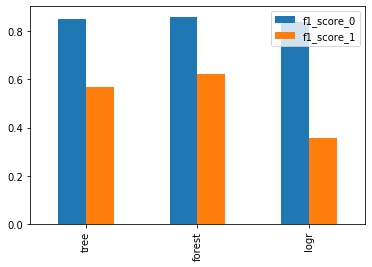

In [ ]:
f1_score_models.plot(kind='bar')

При рассмотрении соотношения обоих параметров - precision и recall - выигрывает снова модель случайного леса. 

#### Все рассмотренные метрики вместе

In [ ]:
metrics_data = pd.concat([accuracy_score_models[['accuracy_score']], precision_score_models[['precision_score_0', 'precision_score_1']], recall_score_models[['recall_score_0', 'recall_score_1']], f1_score_models[['f1_score_0', 'f1_score_1']]], axis=1)
metrics_data

,accuracy_score,precision_score_0,precision_score_1,recall_score_0,recall_score_1,f1_score_0,f1_score_1
tree,0.779160,0.787645,0.744000,0.927273,0.458128,0.851775,0.567073
forest,0.796267,0.809619,0.750000,0.918182,0.532020,0.860490,0.622478
logr,0.740280,0.732538,0.821429,0.977273,0.226601,0.837390,0.355212


In [ ]:
print('---------------------tree---------------------')
print(classification_report(target_test, predictions_tree))
print('---------------------forest---------------------')
print(classification_report(target_test, predictions_forest))
print('---------------------logr---------------------')
print(classification_report(target_test, predictions_logr))

---------------------tree---------------------
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       440
           1       0.74      0.46      0.57       203

    accuracy                           0.78       643
   macro avg       0.77      0.69      0.71       643
weighted avg       0.77      0.78      0.76       643

---------------------forest---------------------
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       440
           1       0.75      0.53      0.62       203

    accuracy                           0.80       643
   macro avg       0.78      0.73      0.74       643
weighted avg       0.79      0.80      0.79       643

---------------------logr---------------------
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       440
           1       0.82      0.23      0.36       203

    accuracy                           

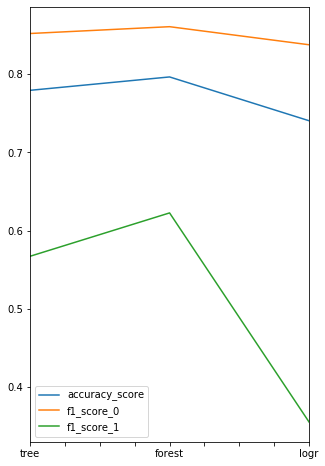

In [ ]:
metrics_data[['accuracy_score', 'f1_score_0', 'f1_score_1']].plot(figsize=(5,8))

По основным параметрам - accuracy и f-мера - модель, обученная алгоритмом случайного леса, лучше остальных проиводит классификацию.

#### Вывод

По основным параметрам - accuracy и f-мера - модель, обученная алгоритмом случайного леса, лучше остальных проиводит классификацию, то есть адекватнее других предлагает абоненту подходящий тариф. 

### Сравнение выбранной модели с моделью фиктивного классификатора.

Для проверки модели на адекватность попробуем использовать фиктивный классификатор (тип классификатора, который не генерирует понимание данных и классифицирует данные с использованием только простых правил). Попробуем DummyClassifier.

Обучим модель 

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(features_train, target_train)
predictions_dummy = dummy_clf.predict(features_valid)

In [ ]:
confusion_matrix_test_dummy = confusion_matrix(target_test, predictions_dummy)
confusion_matrix_test_dummy_df = pd.DataFrame(confusion_matrix_test_dummy, columns = ['dummy_predicted_0', 'dummy_predicted_1'])
confusion_matrix_test_dummy_df

,dummy_predicted_0,dummy_predicted_1
0,440,0
1,203,0


Классификатор записал всех в "Смарт", не глядя. 

Посмотрим на основные метрики модели случайного леса и dummy

In [ ]:
print('---------------------forest---------------------')
print(classification_report(target_test, predictions_forest))
print('---------------------dummy---------------------')
print(classification_report(target_test, predictions_dummy))

---------------------forest---------------------
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       440
           1       0.75      0.53      0.62       203

    accuracy                           0.80       643
   macro avg       0.78      0.73      0.74       643
weighted avg       0.79      0.80      0.79       643

---------------------dummy---------------------
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       440
           1       0.00      0.00      0.00       203

    accuracy                           0.68       643
   macro avg       0.34      0.50      0.41       643
weighted avg       0.47      0.68      0.56       643



- Accuracy такой шуточной модели равен 0.68 - это меньше, чем у всех созданных нами моделей, но порог неочевидный. Вероятно, мы можем принять значение accuracy в 0.68 как "порог адекватности" модели на данной выборке. Тогда выбранная нами модель случайного леса с accuracy 0.80 может быть признана адекватной.
- Все метрики предсказаний "Ультра" у dummy равны 0, так как класс "Ультра" пуст. 
- Precision равна accuracy. 
- Recall равна 1 (действительно все "Смарт" попали в "Смарт", потому что все данные в "Смарт").

#### Вывод

Лучшей для нашей задачи и адекватной нами была признана модель случайного леса.

## Общий вывод

Мы обучили множество моделей решающего дерева, случайного леса и логистической регрессии, выбрали в каждой категории самую точную. Проверка на тестовой модели на точность, а так же на такие метрики, как precision и recall, и их гармоническое среднее значение - f1-мера, показала, что **для задачи предложить по имеющимся данным подходящий абоненту тариф больше подходит модель случайного леса**. Однако, при бОльшем количестве обучающих данных, есть вероятность лучшего результата у модели логистической регрессии. 